In [1]:
import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split

import unicodedata
import re
import numpy as np
import os
import io
import time 

In [2]:
# 下载文件
path_to_zip = tf.keras.utils.get_file(
    'spa-eng.zip', origin='http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip',
    extract=True)

path_to_file = os.path.dirname(path_to_zip)+"/spa-eng/spa.txt"

处理西班牙语中的重音 西班牙语中经常会出现带重音的字母，如 á，我们希望把它转换成英文中的 a。 unidecode 库可以将任何 unicode 字符串音译为 ascii 文本中最接近的可能表示形式。 相关代码为：

In [3]:
def unicode_to_ascii(s):
    output = []
    for c in unicodedata.normalize('NFD', s):
        if unicodedata.category(c) != 'Mn':
            output.append(c)
    return ''.join(output)
#或者 当然也可以采用下面这种更简洁的写法。
def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn')

其中：unicodedata.normalize(‘NFD’, s) 返回标准化后的文本，如：

In [4]:
test = u'¿Váy:?'
print(unicodedata.normalize('NFD', test))
print(test)
print(len(unicodedata.normalize('NFD', test)))
print(len(test))

¿Váy:?
¿Váy:?
7
6


虽然打印出来发现跟没标准化时的一样，但是通过打印长度可以看出，标准化后的文本会比之前的文本多出一个

In [5]:
# for c in unicodedata.normalize('NFD', test):
#     print(c)

通过打印标准化文本中的每个单词，我们发现标准化后多出一个单词的原因是它将带重音的单词分成了两个单词。

然后，我们使用 unicodedata.category( c ) 来判断这个单词是不是重音，如果是重音的话，它会返回 ‘Mn’，如：

In [6]:
# for c in unicodedata.normalize('NFD', test):
#     print(c)
#     print(unicodedata.category(c))

处理ascii文本

In [7]:
def preprocess_sentence(w):
    w = unicode_to_ascii(w.lower().strip())
    
    w = re.sub(r"([?.!,¿])", r" \1 ", w)
    w = re.sub(r'[" "]+', " ", w)

    w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)

    w = w.strip()
    
    w = '<start> ' + w + ' <end>'
    return w

其中：

w.lower().strip() 将所有字母转换成小写字母； unicode_to_ascii(test.lower().strip()) 去掉重音； re.sub(r"([?.!,¿])", r" \1 ", w) 在单词与跟在其后的标点符号（"?", “.”, “!”, “,”, “¿”）之间插入一个空格； re.sub(r’[" "]+’, " ", w) 将连在一起的多个空格合并为一个空格； re.sub(r"[^a-zA-Z?.!,¿]+", " ", w) 除了 (a-z, A-Z, “.”, “?”, “!”, “,”, “¿”)之外，将所有字符替换为空格； w.strip() 用来去除头尾空格； ’ ’ + w + ’ ’ 给句子加上开始和结束标记，以便模型知道何时开始和结束预测。 仍用之前的 test 举例：

In [8]:
w = test.lower().strip()
# '¿váy:?'
w = unicode_to_ascii(w)
# '¿vay:?'
w = re.sub(r"([?.!,¿])", r" \1 ", w)
# ' ¿ vay: ? '
w = re.sub(r'[" "]+', " ", w)
# ' ¿ vay: ? '
w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)
# ' ¿ vay ? '
w = w.strip()
# '¿ vay ?'
w = '<start> ' + w + ' <end>'
# '<start> ¿ vay ? <end>'

因为英文中不存在 ‘¿’ 标点符号，所以在处理西班牙语文本时，我们最后要将其编码为 ‘utf-8’ 格式：

1.5 返回单词对

我们需要返回这样格式的单词对：[ENGLISH, SPANISH]。

In [9]:
def create_dataset(path, num_examples):
    #strip() 方法用于移除字符串头尾指定的字符（默认为空格或换行符）或字符序列。
    lines = io.open(path, encoding='UTF-8').read().strip().split('\n')

    word_pairs = [[preprocess_sentence(w) for w in l.split('\t')]  for l in lines[:num_examples]]

    return zip(*word_pairs)

In [10]:
# 其中：
# io.open(path_to_file, encoding=‘UTF-8’).read() 用来输出编码后的文本；.strip() 用来去掉文本头尾的空格；.split(’\n’) 使原来的一串字符串按 ‘\n’ 划分为很多字符串，然后放到一个列表中。

# num_examples 表示要返回单词对的对数，当 num_examples=None 时，返回所有单词对。

# 比如：

In [11]:
en, sp = create_dataset(path_to_file, 3)
print(en)
print(sp)

('<start> go . <end>', '<start> go . <end>', '<start> go . <end>')
('<start> ve . <end>', '<start> vete . <end>', '<start> vaya . <end>')


**1.6 生成文档词典
text.Tokenizer 类用来对文本中的词进行统计计数，生成文档词典，以支持基于词典位序生成文本的向量表示。

In [12]:
def tokenize(lang):
    lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
    lang_tokenizer.fit_on_texts(lang)

    tensor = lang_tokenizer.texts_to_sequences(lang)

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor,
                                                            padding='post')

    return tensor, lang_tokenizer

其中 fit_on_text(lang) 使用一系列文档来生成 token 词典，lang 是一个列表，每个元素为一个文档。输出的 lang_tokenizer 即为基于以上文档生成的词典。

tensor = lang_tokenizer.texts_to_sequences(lang) 将多个文档转换为 word 下标的向量形式，shape 为 [len(texts)，len(text)] 即 (文档数，每条文档的长度)。

tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding=‘post’) 的操作是先遍历一遍上一步得到的列表中的每个元素，找出最长的一个元素（即包含的单词最多），然后把所有元素都用 0 进行扩充至最长元素的长度。

比如，我们取前25个文本进行实验：

In [13]:
targ_lang, inp_lang = create_dataset(path_to_file, 25)
lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
lang_tokenizer.fit_on_texts(targ_lang)
tensor1 = lang_tokenizer.texts_to_sequences(targ_lang)
tensor2 = tf.keras.preprocessing.sequence.pad_sequences(tensor1, padding='post')
print('tensor1: ', tensor1)
print('tensor2: ', tensor2)

tensor1:  [[1, 5, 4, 2], [1, 5, 4, 2], [1, 5, 4, 2], [1, 5, 4, 2], [1, 13, 4, 2], [1, 9, 3, 2], [1, 9, 4, 2], [1, 14, 15, 2], [1, 6, 3, 2], [1, 6, 3, 2], [1, 6, 3, 2], [1, 7, 3, 2], [1, 7, 3, 2], [1, 7, 3, 2], [1, 10, 3, 2], [1, 10, 4, 2], [1, 8, 3, 2], [1, 8, 3, 2], [1, 8, 3, 2], [1, 11, 3, 2], [1, 11, 4, 2], [1, 5, 12, 4, 2], [1, 5, 12, 4, 2], [1, 16, 3, 2], [1, 17, 18, 4, 2]]
tensor2:  [[ 1  5  4  2  0]
 [ 1  5  4  2  0]
 [ 1  5  4  2  0]
 [ 1  5  4  2  0]
 [ 1 13  4  2  0]
 [ 1  9  3  2  0]
 [ 1  9  4  2  0]
 [ 1 14 15  2  0]
 [ 1  6  3  2  0]
 [ 1  6  3  2  0]
 [ 1  6  3  2  0]
 [ 1  7  3  2  0]
 [ 1  7  3  2  0]
 [ 1  7  3  2  0]
 [ 1 10  3  2  0]
 [ 1 10  4  2  0]
 [ 1  8  3  2  0]
 [ 1  8  3  2  0]
 [ 1  8  3  2  0]
 [ 1 11  3  2  0]
 [ 1 11  4  2  0]
 [ 1  5 12  4  2]
 [ 1  5 12  4  2]
 [ 1 16  3  2  0]
 [ 1 17 18  4  2]]


我们也可以查看生成的词典：

In [14]:
lang_tokenizer.index_word

{1: '<start>',
 2: '<end>',
 3: '!',
 4: '.',
 5: 'go',
 6: 'fire',
 7: 'help',
 8: 'stop',
 9: 'run',
 10: 'jump',
 11: 'wait',
 12: 'on',
 13: 'hi',
 14: 'who',
 15: '?',
 16: 'hello',
 17: 'i',
 18: 'ran'}

我们也可以查看生成的词典：

# 1.7 加载数据集

In [15]:
def load_dataset(path, num_examples=None):
    # 创建经过处理后的输入输出对
    targ_lang, inp_lang = create_dataset(path, num_examples)

    input_tensor, inp_lang_tokenizer = tokenize(inp_lang)
    target_tensor, targ_lang_tokenizer = tokenize(targ_lang)

    return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer

num_examples = 117000
input_tensor, target_tensor, inp_lang, targ_lang = load_dataset(path_to_file, num_examples)

1.8 计算目标张量的最大长度

In [16]:
def max_length(tensor):
    return max(len(t) for t in tensor)
    
max_length_targ, max_length_inp = max_length(target_tensor), max_length(input_tensor)

1.9 划分训练集和测试集

In [17]:
# 采用 80 - 20 的比例切分训练集和验证集
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)

# 显示长度
print(len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val))

93600 93600 23400 23400


1.10 将数字向量转化为文本

In [18]:
def convert(lang, tensor):
    for t in tensor:
        if t!=0:
            print ("%d ----> %s" % (t, lang.index_word[t]))

比如我们取 input_tensor_train[0] 数字向量，将其输入 convert(lang, tensor) 函数：

In [19]:
# input_tensor_train[0] = array([1, 6, 11, 7415, 5, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
print ("Input Language; index to word mapping")
convert(inp_lang, input_tensor_train[0])

Input Language; index to word mapping
1 ----> <start>
98 ----> hace
61 ----> solo
22 ----> una
137 ----> hora
4 ----> que
3727 ----> empezaste
39 ----> este
84 ----> trabajo
3 ----> .
2 ----> <end>


1.11 创建一个 tf.data 数据集

In [20]:
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 64
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE
embedding_dim = 256
units = 1024
vocab_inp_size = len(inp_lang.word_index)+1
vocab_tar_size = len(targ_lang.word_index)+1

dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

我们可以查看每次从数据集中取出的样本形状：

In [21]:
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([64, 23]), TensorShape([64, 22]))

这里的1.6-1.11也可以用 tfds.features.text.Tokenizer() 函数来做，大体思路为：

2.1 编码器

首先，我们将每个单词嵌入 embedding_dim 维的空间向量中，然后输入 GRU 单元。

In [22]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
        super(Encoder, self).__init__()
        self.batch_sz = batch_sz
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.enc_units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')

    def call(self, x, hidden):
        x = self.embedding(x)
        output, state = self.gru(x, initial_state = hidden)
        return output, state

    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.enc_units))

在词嵌入层中，样本形状从 (64, 16) 变成 (64, 16, 256)，即每个单词都变成了一个256维的向量。 在含有1024个神经元的 GRU 层中，样本形状又从 (64, 16, 256) 变成 (64, 16, 1024)，GRU 层里的隐藏向量的形状为 (64, 1024)。

In [23]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

# 样本输入
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))

Encoder output shape: (batch size, sequence length, units) (64, 23, 1024)
Encoder Hidden state shape: (batch size, units) (64, 1024)


2.2 Bahdanau 注意力

相关论文参考：BahdanauAttention。

In [24]:
class BahdanauAttention(tf.keras.Model):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, query, values):
        hidden_with_time_axis = tf.expand_dims(query, 1)

        score = self.V(tf.nn.tanh(
            self.W1(values) + self.W2(hidden_with_time_axis)))

        attention_weights = tf.nn.softmax(score, axis=1)

        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

这里的 values 其实就是编码器中输出的结果，经过含10个神经元的 Dense 层之后，其形状从 (64, 16, 1024) 变成了 (64, 16, 10)。

这里的 query 其实就是编码器中输出的隐层向量，我们需要将其维度从 (64, 1024) 变成 (64, 1， 1024) 来执行之后的加法以计算分数，将增加维度后的向量经过含10个神经元的 Dense 层之后，其形状从 (64, 1, 1024) 变成了 (64, 1, 10)。

将以上两个输出相加得到的形状为 (64, 16, 10)，经过含1个神经元的 Dense 层之后得到 score，其形状变成 (64, 16, 1)。

Softmax 默认被应用于最后一个轴，但是这里我们想将它应用于第二个轴（即 axis=1），因为分数 （score） 的形状是 (批大小，最大长度，隐藏层大小)。最大长度是我们的输入的长度。因为我们想为每个输入分配一个权重，所以 softmax 应该用在这个轴上。经过 Softmax 层之后，得到的注意力权重形状和 score 的形状相同，都是 (64, 16, 1)。 【注】Softmax 的不同的轴的计算规则参考：tf.nn.softmax(x, axis)里axis起什么作用？

将注意力权重和 values 相乘，得到上下文向量，其形状为 (64, 16, 1024)。此向量也就是加了权重的编码向量。将上下文向量基于第二个轴求和（原因与之前相同），得到最终的上下文向量，其形状为 (64, 1024)。

In [25]:
attention_layer = BahdanauAttention(10)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

Attention result shape: (batch size, units) (64, 1024)
Attention weights shape: (batch_size, sequence_length, 1) (64, 23, 1)


2.3 解码器

In [26]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
        super(Decoder, self).__init__()
        self.batch_sz = batch_sz
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.dec_units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
        self.fc = tf.keras.layers.Dense(vocab_size)
        
        self.attention = BahdanauAttention(self.dec_units)

    def call(self, x, hidden, enc_output):
        context_vector, attention_weights = self.attention(hidden, enc_output)

        x = self.embedding(x)

        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
        
        output, state = self.gru(x)
        
        output = tf.reshape(output, (-1, output.shape[2]))

        x = self.fc(output)

        return x, state, attention_weights

在解码器中，首先利用注意力层获得上下文向量 (64, 1024) 和注意力权重 (64, 16, 1)。

将输入通过词嵌入层，其形状从 (64, 1) 变成了 (64, 1, 256)。

在上下文向量上添加一个维度，使它的形状变成 (64, 1, 1024)，然后和通过词嵌入层的输入合并，得到形状为 (64, 1, 1280) 的向量。

将合并后的向量传送到 GRU，得到输出向量 (64, 1, 1024) 和隐藏状态 (64, 1024)。

将输出向量以最后一维的维数不变的形式转换成二维数组，即形状为 (64*1, 1024)。

最后，将这个向量通过一个含有词汇表大小 (4935) 个神经元的全连接层，得到最终输出 (64, 4935)。

In [27]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

sample_decoder_output, _, _ = decoder(tf.random.uniform((64, 1)),
                                      sample_hidden, sample_output)

print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

Decoder output shape: (batch_size, vocab size) (64, 12512)


3、定义优化器和损失函数

每次输入解码器的向量是一个批次中所有文本中的一个单词，即每次输入的向量形状都是 (64, 1)。

当输入的向量中出现0元素，说明这个元素所在的文本已经结束了，这个文本不再参与损失的计算，所以在计算损失的时候，要使用掩膜处理，将已结束文本的损失置零。

In [28]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)


# 4、训练

4.1 梯度下降

a. 将输入传送至编码器，编码器返回编码器输出和编码器隐藏层状态。 b. 将编码器输出、编码器隐藏层状态和解码器输入（即 ‘’ ）传送至解码器。 c. 解码器返回预测和解码器隐藏层状态。 d. 解码器隐藏层状态被传送回模型，预测被用于计算损失。 e. 使用教师强制（teacher forcing）决定解码器的下一个输入。 PS：教师强制是将目标词作为下一个输入传送至解码器的技术。 f. 最后一步是计算梯度，并将其应用于优化器和反向传播。

In [ ]:
@tf.function
def train_step(inp, targ, enc_hidden):
    loss = 0

    with tf.GradientTape() as tape:
        enc_output, enc_hidden = encoder(inp, enc_hidden)

        dec_hidden = enc_hidden

        dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)
        
        for t in range(1, targ.shape[1]):
            predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

            loss += loss_function(targ[:, t], predictions)

            dec_input = tf.expand_dims(targ[:, t], 1)

    batch_loss = (loss / int(targ.shape[1]))

    variables = encoder.trainable_variables + decoder.trainable_variables

    gradients = tape.gradient(loss, variables)

    optimizer.apply_gradients(zip(gradients, variables))

    return batch_loss

4.2 训练过程

In [ ]:
dataset_name = 'spanish'
if not os.path.exists('models_'+dataset_name):
    os.mkdir('models_'+dataset_name)

EPOCHS = 30

for epoch in range(EPOCHS):
    start = time.time()

    enc_hidden = encoder.initialize_hidden_state()
    total_loss = 0

    for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
        batch_loss = train_step(inp, targ, enc_hidden)
        total_loss += batch_loss

        if batch % 100 == 0:
            print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                         batch,
                                                         batch_loss.numpy()))

    print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
    print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))
    if epoch % 5 == 0:
        encoder.save_weights('models_'+dataset_name+'/encoder_epoch-{}.h5'.format(str(epoch+1)))
        decoder.save_weights('models_'+dataset_name+'/decoder_epoch-{}.h5'.format(str(epoch+1)))

# 5、预测

5.1 预测函数

1、用 preprocess_sentence 函数处理ascii文本；
2、将文本转换成数字向量，并进行填充；
3、将数字向量转化为张量；
4、初始化编码器的隐藏状态；
5、将数字张量和初始化隐藏状态输入编码器；
6、初始化解码器输入；
7、逐字输入解码器，得到预测的文本。

In [29]:
def evaluate(sentence):
    
    encoder.load_weights('./encoder_epoch-26.h5', by_name=True)
    decoder.load_weights('./decoder_epoch-26.h5', by_name=True)
    
    attention_plot = np.zeros((max_length_targ, max_length_inp))

    sentence = preprocess_sentence(sentence)

    inputs = [inp_lang.word_index[i] for i in sentence.split(' ')]
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                           maxlen=max_length_inp,
                                                           padding='post')
    inputs = tf.convert_to_tensor(inputs)

    result = ''

    hidden = [tf.zeros((1, units))]
    enc_out, enc_hidden = encoder(inputs, hidden)

    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)

    for t in range(max_length_targ):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                             dec_hidden,
                                                             enc_out)

        # 存储注意力权重以便后面制图
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = attention_weights.numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()

        result += targ_lang.index_word[predicted_id] + ' '

        if targ_lang.index_word[predicted_id] == '<end>':
            return result, sentence, attention_plot

        # 预测的 ID 被输送回模型
        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention_plot

5.2 注意力权重制图函数

In [30]:
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

5.3 翻译函数

In [31]:
def translate(sentence):
    result, sentence, attention_plot = evaluate(sentence)

    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))

    attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
    plot_attention(attention_plot, sentence.split(' '), result.split(' '))

Input: <start> hace mucho frio aqui . <end>
Predicted translation: it s very cold here . <end> 


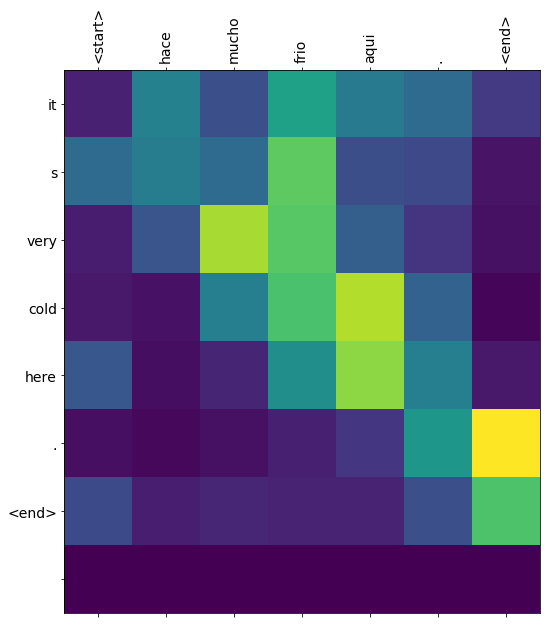

In [32]:
translate(u'hace mucho frio aqui.')

Input: <start> empezamos . <end>
Predicted translation: we started . <end> 


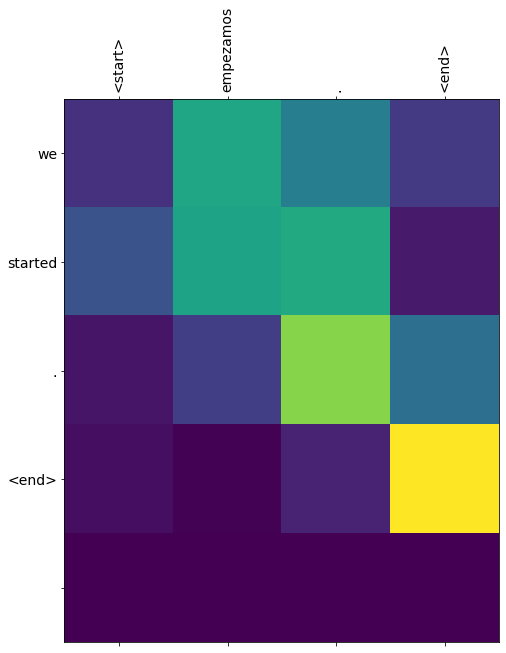

In [33]:
translate(u'Empezamos.')

Input: <start> empezamos . <end>
Predicted translation: we started . <end> 


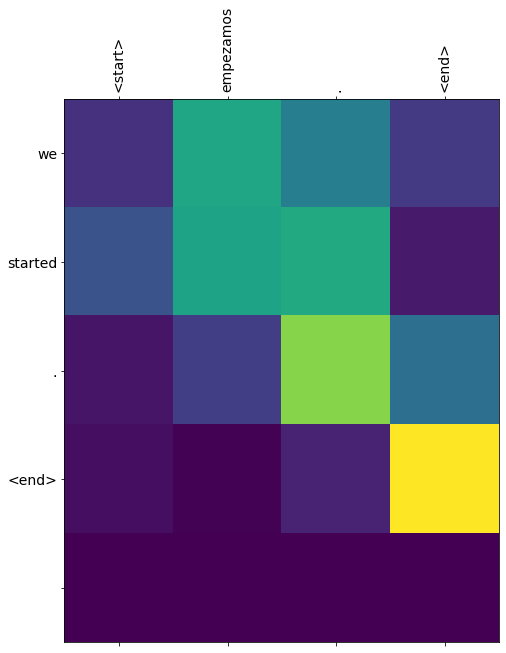

In [34]:
translate(u'Empezamos.')

Input: <start> aun faltan algunas palabras . <end>
Predicted translation: there are still some words . <end> 


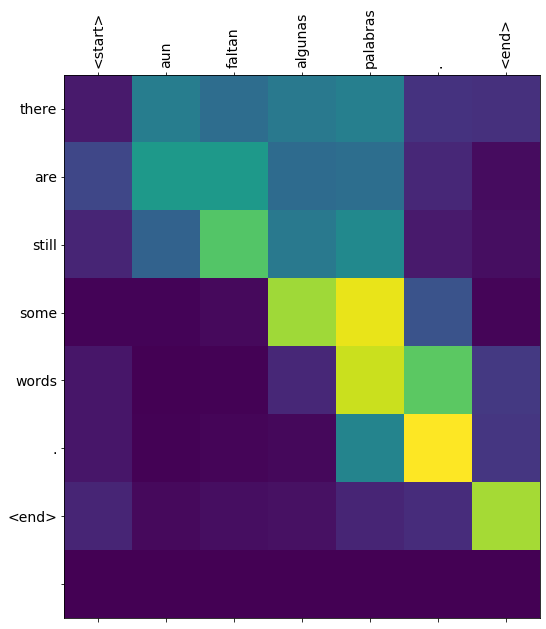

In [42]:
translate(u'Aún faltan algunas palabras.')